
# Issue: [Word Distribution Trends](https://github.com/humlab/welfare_state_analytics/issues/10)

To consider:

- How to normalize the distributions? Normalize each words distribution to 1.
- What clustering to use? Ward? Try K-means to start with.
- UX two select different kinds of clusters

## Find words that deviates the most from uniform distribution
1. Compute using a goddness of fit test (e.g. chi-square test)
1. Visualisera distribution of "godness value" ("how many word deviates how much")
1. List words that for which the null-hypothesis is true 0.05

## Compute distribution clusters for most deviating words
1. Select n (=500) words that deviates the most.
1. Select n clusters that covers 9+% all words.
1. Visualize single cluster
    - Mean / scatter / box-plot
1. Visualize all clusters
    - Each represented as a mean curve
1. Export individual words for each cluster

Notes:

- Word filters

Issues:

- Scale insted of normalize???


References
----------

- [1] Lowry, Richard.  "Concepts and Applications of Inferential Statistics". Chapter 8. https://web.archive.org/web/20171022032306/http://vassarstats.net:80/textbook/ch8pt1.html
- [2] "Chi-squared test", https://en.wikipedia.org/wiki/Chi-squared_test



In [1]:
%load_ext autoreload
%autoreload 2

import operator
import logging

logging.basicConfig(level=logging.INFO)

from westac.common import vectorized_corpus

import scipy
import scipy.stats
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib
import matplotlib.pyplot as plt

from westac.common.utility import flatten
from westac.common         import goodness_of_fit as gof

%matplotlib inline

matplotlib.rcParams["figure.figsize"] = [20, 4.8] 
pd.set_option('display.max_rows', 1000)

### Load corpus

In [47]:
v_corpus = vectorized_corpus.VectorizedCorpus\
            .load('SOU_1945-1989_L0_+N_+S', folder='./output')\
            .group_by_year()\
            .slice_by_n_top(25000)
            #.normalize(axis=1)
            #.slice_by_n_top(10000)
            #.normalize(axis=1)
            #.slice_by_n_count(1000)\

# Normalize to relative frequency (total sum of all words equals 1.0 for each year)
v_ny_corpus = v_corpus.normalize(axis=1)

# Normalize word's relative frequency (sum of word's frequency over all years equals 1.0)
v_ny_nw_corpus = v_ny_corpus.normalize(axis=0)

# Normalize to word's relative frequency (sum of word's frequency over all years equals 1.0)
# then scaled back to year 1s magnitude
v_ynm_corpus = v_corpus.normalize(norm='l1', keep_magnitude=True)

_ = v_corpus.stats()
_ = v_ny_corpus.stats()
_ = v_ny_nw_corpus.stats()

n_top_tokens = v_corpus.n_top_tokens(1000)

df = pd.DataFrame({ 'word': list(n_top_tokens.keys()), 'word_count': list(n_top_tokens.values()) })


In [72]:
plt.plot(v_corpus.data.sum(axis=1), xlabels=[str(x) for x in range(1045, 1990)])

In [128]:
# Utlity functions


years = [ y for y in range(1945, 1990)]

#plt.plot(years,v_corpus.normalize(norm='l1', keep_magnitude=True).data[:,v_corpus.token2id['och']], color="red")
#plt.bar(years, v_corpus.data[:,v_corpus.token2id['och']])

d = [81.0] * 45

#d = v_ynm_corpus.data[:,0]
print(d)

scipy.stats.chisquare(d)


[81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0]


Power_divergenceResult(statistic=0.0, pvalue=1.0)

### Chi-square goodness-of-fit

H0: 
HA

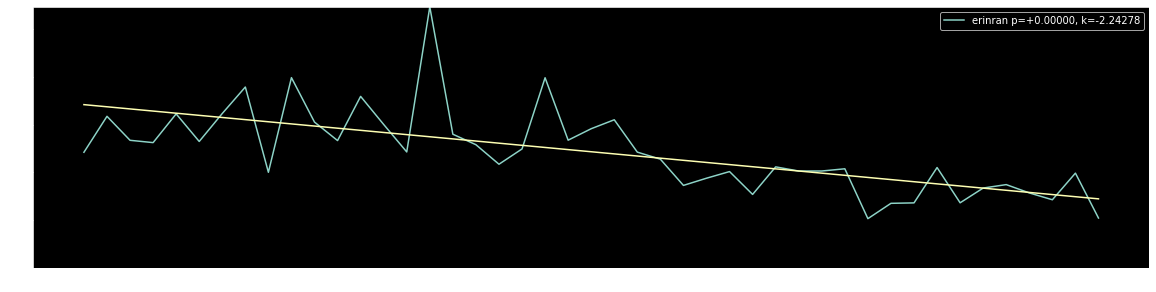

In [196]:

def fit_ordinary_least_square(ys):
    xs = sm.add_constant(np.arange(len(ys))) #0.0, len(ys), 1.0))
    model = sm.OLS(endog=ys, exog=xs)
    result = model.fit()
    return result

def plot_goodness_of_fit_chisquare(x_corpus, *words):

    indices = [ x_corpus.token2id[w] for w in words if w in x_corpus.token2id ]

    if len(indices) == 0:
        print("Not found! Please select other token(s)")
        return

    p_values = [
        scipy.stats.chisquare(x_corpus.bag_term_matrix[:,i], axis=0)[1]
            for i in indices
    ]

    ols_results = [
        gof.fit_ordinary_least_square2(x_corpus.data[:, indices[i]])
            for i in range(0, len(indices))
    ]
    
    ols_slope = [ z[1] for z in ols_results ]

    T = [
        i + 1945 for i in range(x_corpus.bag_term_matrix.shape[0])
    ]

    labels = [
        '{} p={:+.5f}, k={:+.5f}'.format(x_corpus.id2token[indices[i]], p_values[i], ols_slope[i])
            for i in range(len(indices))
    ]

    data = tuple(flatten([ (T, x_corpus.bag_term_matrix[:,i]) for i in indices ]))
    
    #plt.figure(figsize=(15,7))
    #if len(words) == 1:
    #    plt.bar(*data)
    #else:
    plt.plot(*data)

    for ols_result in ols_results:
        m, k, p_values, xs, ys = ols_result
        xs = [ x + 1945 for x in xs ]
        plt.plot(xs, ys)

    plt.ylim((0, x_corpus.bag_term_matrix[:,indices].max()))
    plt.gca().legend(tuple(labels))
    plt.show()


# Negativa: huruvida åvilar
# Positiva: använder
# Uniforma: följas
plot_goodness_of_fit_chisquare(v_ynm_corpus, 'erinran')


In [130]:


def compute_g_test(ys):
    try:
        print(ys)
        g, g_p, dof, expctd = scipy.stats.chi2_contingency(ys, lambda_="log-likelihood")
        return g, g_p
    except:
        return np.nan, np.nan

    
def compute_goodness_of_fit(x_corpus, n_top):

    n_top_tokens = x_corpus.n_top_tokens(n_top)

    indices = [ x_corpus.token2id[w] for w in n_top_tokens ]

    V = x_corpus.data[:,indices]

    # Chisquare goodness-of-fit test when expected is uniform distribution
    chi2s, chi2s_p = scipy.stats.chisquare(V, axis=0)

    # Slopes for linear regression (ordinary least square)
    ols_slopes = [
        fit_ordinary_least_square(V[:,i]).params[1]
            for i in range(0, V.shape[1])
    ]
    
    # G-test
    g_test_result = [
        compute_g_test(V[:,i])
            for i in range(0, V.shape[1])
    ]

    df = pd.DataFrame({
        'token': list(n_top_tokens.keys()),
        'count': list(n_top_tokens.values()),
        'chi2': chi2s,
        'chi2_p': chi2s_p,
        'slope': ols_slopes,
        'g': [ g[0] for g in g_test_result ],
        'g_p': [ g[1] for g in g_test_result ]
    })

    return df


df = compute_goodness_of_fit(v_ynm_corpus, 10)
df.sort_values('slope', inplace=True, ascending=False)
display(df)

[119737.         120807.74049693 122156.71529955 120973.36697738
 121092.72138055 122163.65315074 121465.66084555 126605.14059073
 113536.27317546 117840.96850154 118681.7543084  125860.70618372
 120586.77984518 119229.32032814 123804.55324856 122192.52153991
 119663.71887524 122377.371629   116319.42836609 109492.28815505
 115493.04490225 118412.11295887 114561.08242213 111811.79367931
 115595.03705827 109824.33404572 114797.85433366 107681.86795743
 115170.97001103 110495.23909833 107290.12449456 109281.48264822
 113897.736012   112173.69660496 107514.51064928 112277.8676035
  97748.01637862 105760.38242603 106329.09353474 102831.64672177
  94336.53932292  99573.82343195 105610.31206821 101306.02419635
 109091.17259103]
[ 96967.          99866.19191991  94848.70906552 101657.68727808
  97239.04055291 101725.23490095 105008.84607118 100940.6122868
 100461.92352792 110142.2384929  103807.10468239 102759.11619411
 111811.20083248  95494.8476523  100971.86196646 107406.36863084
 104757.6

,token,count,chi2,chi2_p,slope,g,g_p
4,som,3969701,44264.909511,0.0,631.066244,0.0,1.0
1,att,5780868,22095.891252,0.0,402.748822,0.0,1.0
8,det,2508311,23265.872698,0.0,307.689391,0.0,1.0
5,en,3180341,17053.942844,0.0,273.367716,0.0,1.0
2,och,5589116,12266.363669,0.0,217.009902,0.0,1.0
9,med,2496731,2896.110885,0.0,-106.867792,0.0,1.0
7,den,2873133,6667.589173,0.0,-110.794207,0.0,1.0
6,till,3135285,8747.697829,0.0,-207.993467,0.0,1.0
3,för,4360419,12188.959195,0.0,-236.658180,0.0,1.0
0,av,6147751,23250.471805,0.0,-501.532714,0.0,1.0


In [ ]:


def compute_chisquare(x_corpus, n_top):

    n_top_tokens = x_corpus.n_top_tokens(n_top)

    indices = [ x_corpus.token2id[w] for w in n_top_tokens ]

    V = v_corpus.data[:,indices]

    # Chisquare goodness-of-fit test when expected is uniform distribution
    chi2s, chi2s_p = scipy.stats.chisquare(V, axis=0)

    # Slopes for linear regression (ordinary least square)
    ols_slopes = [
        fit_ordinary_least_square(V[:,i]).params[1]
            for i in range(0, V.shape[1])
    ]
    
    # G-test
    g, g_p, dof, expctd = scipy.stats.chi2_contingency(V.T, lambda_="log-likelihood")
    df = pd.DataFrame({
        'token': list(n_top_tokens.keys()),
        'count': list(n_top_tokens.values()),
        'chi2': chi2s,
        'chi2_p': chi2s_p,
        'slope': ols_slopes,
        'g': g,
        'g_p': g_p
    })

    return df


df = compute_chisquare(v_yn_corpus, 10000)

df.sort_values('chi2', ascending=False)


In [140]:
plot_words(v_ny_corpus, ["och"])
plot_words(v_ny_corpus, ["motiverats"])


In [31]:

# Count how many word p-values (times 100) ends ups in each

for x_corpus in [v_corpus, v_ny_corpus, v_ny_nw_corpus]:

    t_corpus = x_corpus.slice_by_n_top(100)

    buckets = [0] * 101
    for i in range(0, t_corpus.data.shape[1]):
        _, p = scipy.stats.chisquare(t_corpus.data, axis=0)
        for j in range(0, len(p):
            buckets[int(100*p[j])] += 1

    print(buckets)


In [138]:

for x_corpus in [v_corpus, v_ny_corpus, v_ny_nw_corpus]:
    plot_words(x_corpus, ["samhälle"])


In [ ]:
def fit_ordinary_least_square(ys):
    xs = sm.add_constant(np.linspace(0, 1, len(y)))
    regressor = sm.OLS(endog=ys, exog=xs)
    model = regressor.fit()
    return model
    

In [17]:
import unittest
import numpy as np
import pandas as pd


import scipy
from scipy.cluster.hierarchy import dendrogram, linkage # pylint: disable=unused-import
from matplotlib import pyplot as plt # pylint: disable=unused-import

        v_corpus = vectorizer\
            .fit_transform(corpus)\
            .group_by_year()\
            .normalize()\
            .slice_by_n_count(0)

        X2 = scipy.stats.chisquare(v_corpus.term_bag_matrix, f_exp=None, ddof=0, axis=0) # pylint: disable=unused-variable

        # Use X2 so select top 500 words... (highest Power-Power_divergenceResult)
        # Ynw = largest_by_chisquare()
        #print(Ynw)

        linked = linkage(v_corpus.term_bag_matrix, 'ward') # pylint: disable=unused-variable
        #print(linked)

        ##labels = [ v_corpus.id2token[x] for x in indices ] # pylint: disable=unused-variable

        #plt.figure(figsize=(24, 16))
        #dendrogram(linked, orientation='top', labels=labels, distance_sort='descending', show_leaf_counts=True)
        #plt.show()

def plot_dists(v_corpus):
    df = pd.DataFrame(v_corpus.bag_term_matrix.toarray(), columns=list(v_corpus.get_feature_names()))
    df['year'] = df.index + 45
    df = df.set_index('year')
    df['year'] =  pd.Series(df.index).apply(lambda x: v_corpus.document_index[x][0])
    df[['krig']].plot() #.loc[df["000"]==49]


In [35]:
v_corpus.to_n_top_dataframe(100)

## Some word statistics

In [4]:
def stat_count_by_n_count(v_corpus, n_bins=100, cumulative=False):

    # n_bins = max(v_corpus.word_counts.iteritems(), key=operator.itemgetter(1))[0]

    bins = [ 0 ] * (n_bins + 1)

    for _, n_count in v_corpus.word_counts.items():
        bins[min(n_count, n_bins - 1)] += 1

    if cumulative:
        bins = np.cumsum(bins).tolist()

    return bins

def letters_in_corpus(v_corpus):
    letters = {}
    for w,n in v_corpus.word_counts.items():
        for c in w:
            letters[c] = letters.get(c,0) + n
    return ''.join(list(sorted(letters.keys())))

stat_count_by_n_count(v_corpus)


In [41]:
import sklearn
n = sklearn.preprocessing.normalize

X = np.array([
    [ 1.,  2.,  4.],
    [ 2.,  0.,  0.],
    [ 4.,  1.,  3.]
])

X0 = X[0]
print(X0)

Y = n(X, norm='l1', axis=1)
Y0 = Y[0]

print(Y)
print(Y0)

K = X0 / Y0

print(K)
print(Y * K)


In [20]:
import scipy.stats

f_obs = [ 1000, 1000, 1005, 1005, 1005 ]
chi2, p = scipy.stats.chisquare(f_obs, f_exp=None, ddof=0, axis=0)
print(chi2, p)

f_obs = [ 10000, 10000, 10300, 10250, 10050 ]
chi2, p = scipy.stats.chisquare(f_obs, f_exp=None, ddof=0, axis=0)
print(chi2, p)
# Chi2 ökar med magnituden




0.029910269192422727 0.9998892806821573
8.201581027667984 0.08446694678903657
